__analisis exploratorio datos shiptrack__
# Arrivals report
son solo del pasado... !!!!!!!

In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import pickle
import re

In [2]:
file_list = sorted(Path.cwd().glob('[0-9]*ShipTracks*.xlsx'))

## descriptivo
### que son las columnas

In [3]:
afile = file_list[0]
columns = pd.read_excel(afile,'Sheet1',header=1).columns
columns

Index(['Name', 'IMO', 'MMSI', 'Callsign', 'Length', 'Destination', 'ETA',
       'Enter Draught', 'Exit Draught', 'Enter Time', 'Exit Time', 'Duration'],
      dtype='object')

In [4]:
{'Name': 'nombre barco',
 'IMO':'id International Maritime Organization',
 'MMSI':'id Maritime Mobile Service Identity',
 'Callsign':'id radio?',
 'Length':'eslora',
 'Destination':'',
 'ETA':'',
 'Enter Draught':'calado',
 'Exit Draught':'',
 'Enter Time':'',
 'Exit Time':'',
 'Duration':'',
}

{'Name': 'nombre barco',
 'IMO': 'id International Maritime Organization',
 'MMSI': 'id Maritime Mobile Service Identity',
 'Callsign': 'id radio?',
 'Length': 'eslora',
 'Destination': '',
 'ETA': '',
 'Enter Draught': 'calado',
 'Exit Draught': '',
 'Enter Time': '',
 'Exit Time': '',
 'Duration': ''}

### juntando los datos

In [5]:
df = pd.DataFrame( columns=['filedate',*columns] )

In [6]:
if Path('df.p').is_file():
    with open('df.p','rb') as afile:
        df = pickle.load(afile)
else:
    for afile in file_list:
        tmp = pd.read_excel(afile,'Sheet1',header=1)
        tmp.insert(0, 'filedate', afile.stem.replace(' ShipTracks Web','')[:-3])
        df = pd.concat((df,tmp))
    with open('df.p','wb') as afile:
        pickle.dump(df,afile)

## transformar type

In [7]:
df['Length'] = df['Length'].astype(float)
df.ETA = pd.to_datetime(df.ETA)
df['Enter Time'] = pd.to_datetime(df['Enter Time'])
df['Exit Time'] = pd.to_datetime(df['Exit Time'])
df.Duration = df.Duration.astype('timedelta64[ns]')

C:\Users\FernandoBadilla\AppData\Local\Temp\ipykernel_16536\3984089279.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.ETA = pd.to_datetime(df.ETA)


In [8]:
for c in df.columns:
    print(c,df[c].dtype,sep='\t\t')

filedate		object
Name		object
IMO		float64
MMSI		object
Callsign		object
Length		float64
Destination		object
ETA		datetime64[ns]
Enter Draught		float64
Exit Draught		float64
Enter Time		datetime64[ns]
Exit Time		datetime64[ns]
Duration		timedelta64[ns]


### ignorar 2 digitos entre fecha y Shiptracks (filename)

In [9]:
df.filedate = pd.to_datetime(df.filedate)

### Callsign: quitar caracteres raros

In [10]:
df.Callsign.fillna('',inplace=True)

compiled_pattern = re.compile('[^a-zA-Z0-9]')
def filter_weird_chars(input_string):
    return re.sub(compiled_pattern, '', str(input_string))

df.Callsign = df.Callsign.apply( filter_weird_chars)

### IMO: fill nan 0 para 
    IMO 
     nan		 79 

In [11]:
df.IMO.fillna(0.0,inplace=True)

## basic stats

In [12]:
for c in df.columns:
    print(c,'\n','nan\t\t',df[c].isna().sum(),'\n',df[c].describe(),'\n')

filedate 
 nan		 0 
 count                             8240
mean     2023-02-19 14:49:41.359223296
min                2023-02-03 00:00:00
25%                2023-02-12 00:00:00
50%                2023-02-18 00:00:00
75%                2023-02-27 00:00:00
max                2023-03-09 00:00:00
Name: filedate, dtype: object 

Name 
 nan		 0 
 count       8240
unique      1331
top       PETREL
freq          29
Name: Name, dtype: object 

IMO 
 nan		 0 
 count    8.240000e+03
mean     7.940769e+06
std      3.316915e+07
min      0.000000e+00
25%      0.000000e+00
50%      9.169524e+06
75%      9.580522e+06
max      9.283681e+08
Name: IMO, dtype: float64 

MMSI 
 nan		 0 
 count          8240
unique         1338
top       725003138
freq             12
Name: MMSI, dtype: int64 

Callsign 
 nan		 0 
 count     8240
unique    1322
top           
freq        69
Name: Callsign, dtype: object 

Length 
 nan		 0 
 count    8240.000000
mean       87.295995
std        76.492091
min         1.000000
2

### analisis de nombres
- no se ven muchos problemas de nombre
- IMO el peor, muchos datos en 0, se quita para el analisis

In [13]:
print('Name','Nan','Unique', sep='\t')
for c in ['Name','IMO','MMSI','Callsign']:
    print(c,df[c].isna().sum(),len(df[c].unique()), sep='\t')

Name	Nan	Unique
Name	0	1331
IMO	0	1020
MMSI	0	1338
Callsign	0	1322


In [14]:
# MMSI no tiene ceros (ya fueron arreglados los otros)
len(df.MMSI[df.MMSI==0])

0

#### comparacion cruzada
_1. para cada unico del primer grupo_  
_2. filtro el df por ese primer grupo_  
_3. los agrupo por el segundo grupo_  
_4. veo si los grupos generados tienen columnas con datos no unicos_  

El primer ejemplo es Nombre del barco y agrupar por callsign: Name -> Callsign

Pero es mas efectivo partir con la agrupacion que mas unicos tiene para enconrar mas diferencias  
(y no grupos de 1 fila que nunca podria tener datos no unicos)  
- MMSI -> Name  
- MMSI -> Callsign  

In [15]:
offendingNameCallsign = dict(zip(['Name','MMSI','Callsign'],[0]*4))
for name in df.Name.unique():
    for n,g in df[ df.Name == name ].groupby('Callsign'):
        for c in ['Name','MMSI','Callsign']:
            if len(g[c].unique())!=1:
                offendingNameCallsign[c] += 1
                print('name',name, 'offending col', c, 'uniques',len(g[c].unique()))
                print(g[['Name','MMSI','Callsign']])
#        break
#    break

name RONIA AUSTRAL offending col MMSI uniques 2
              Name       MMSI Callsign
197  RONIA AUSTRAL  725003022   CA7541
70   RONIA AUSTRAL  725003022   CA7541
260  RONIA AUSTRAL  725003022   CA7541
113  RONIA AUSTRAL  725003022   CA7541
157  RONIA AUSTRAL  725003022   CA7541
186  RONIA AUSTRAL  725003022   CA7541
213  RONIA AUSTRAL  725003022   CA7541
194  RONIA AUSTRAL  725003022   CA7541
164  RONIA AUSTRAL  725003022   CA7541
58   RONIA AUSTRAL  725003022   CA7541
664  RONIA AUSTRAL  258110000   CA7541
name ELSI offending col MMSI uniques 2
     Name       MMSI Callsign
439  ELSI  518100233   9M3042
625  ELSI  533132547   9M3042


In [16]:
offendingNameCallsign

{'Name': 0, 'MMSI': 2, 'Callsign': 0}

In [17]:
offendingMMSIName = dict(zip(['Name','MMSI','Callsign'],[0]*4))
for name in df.MMSI.unique():
    for n,g in df[ df.MMSI == name ].groupby('Name'):
        for c in ['Name','MMSI','Callsign']:
            if len(g[c].unique())!=1:
                offendingMMSIName[c] += 1
                print('MMSI',name, 'offending col', c, 'uniques',len(g[c].unique()))
                print(g[['Name','MMSI','Callsign']])
#        break
#    break

MMSI 725003474 offending col Callsign uniques 2
            Name       MMSI Callsign
156  ISLA TAUTIL  725003474   CA8073
83   ISLA TAUTIL  725003474         
371  ISLA TAUTIL  725003474         
335  ISLA TAUTIL  725003474         
122  ISLA TAUTIL  725003474         
56   ISLA TAUTIL  725003474         
68   ISLA TAUTIL  725003474         
62   ISLA TAUTIL  725003474         
110  ISLA TAUTIL  725003474         
106  ISLA TAUTIL  725003474         
408  ISLA TAUTIL  725003474         
57   ISLA TAUTIL  725003474         
MMSI 725000000 offending col Callsign uniques 2
                    Name       MMSI Callsign
191  LM CONSUELO MARIBEL  725000000   CB5308
19   LM CONSUELO MARIBEL  725000000   CB9577
MMSI 413000000 offending col Callsign uniques 2
    Name       MMSI Callsign
466  123  413000000       21
285  123  413000000        0
462  123  413000000        0
449  123  413000000        0
MMSI 760027203 offending col Callsign uniques 2
      Name       MMSI Callsign
423  MATEO  7600

In [18]:
offendingMMSIName

{'Name': 0, 'MMSI': 0, 'Callsign': 6}

In [19]:
offendingMMSICallsign = dict(zip(['Name','MMSI','Callsign'],[0]*4))
for name in df.MMSI.unique():
    for n,g in df[ df.MMSI == name ].groupby('Callsign'):
        for c in ['Name','MMSI','Callsign']:
            if len(g[c].unique())!=1:
                offendingMMSICallsign[c] += 1
                print('MMSI',name, 'offending col', c, 'uniques',len(g[c].unique()))
                print(g[['Name','MMSI','Callsign']])
#        break
#    break

MMSI 725000000 offending col Name uniques 3
                 Name       MMSI Callsign
388  LM DON ADRIAN II  725000000   CB3605
146        DON ADRIAN  725000000   CB3605
62      LM DON NESTOR  725000000   CB3605
MMSI 725000000 offending col Name uniques 2
               Name       MMSI Callsign
144          FARAON  725000000   CB8291
68           FARAON  725000000   CB8291
144  MATIAS IGNACIO  725000000   CB8291
MMSI 538006893 offending col Name uniques 2
               Name       MMSI Callsign
347  HAFNIA STELLAR  538006893    V7ST9
363    CHEM STELLAR  538006893    V7ST9
248    CHEM STELLAR  538006893    V7ST9
1      CHEM STELLAR  538006893    V7ST9
MMSI 701006467 offending col Name uniques 2
         Name       MMSI Callsign
447  LA PAMPA  701006467   LW9657
99   LA PAMPA  701006467   LW9657
571  LA PAMPA  701006467   LW9657
556  LA PAMPA  701006467   LW9657
634  LA PAMPA  701006467   LW9657
122  LA PAMPA  701006467   LW9657
224  LA PAMPA  701006467   LW9657
675  LA_PAMPA  701006467

In [20]:
offendingMMSICallsign

{'Name': 9, 'MMSI': 0, 'Callsign': 0}

#### _NOTA1: usar Name esta ok_
Se podría hacer un algoritmo que con Callsign y MMSI reparen los errores de nombre, pero por mientras se usara nombre que tiene casi mismos unicos que callsign

#### _proximo paso: filtrar por conocidos_
remolcadores, armada de chile, cargueros

## analisis de rutas
### Destination tiene 22 % de nans

In [21]:
np.round( df.Destination.isna().sum() 
         / len(df.Destination) *100
         ,1)

22.3

In [23]:
# se reemplazan por 'noname'
df.Destination.fillna('noname', inplace=True)
df.Destination.isna().sum()

0

### (obvio) duracion es la resta de exit - enter

In [24]:
np.all( df['Exit Time'] - df['Enter Time'] == df.Duration )

True

### fechas

#### malETAs 22% de 1 ene 2024, 4.2% 1970
    ETA 
     count                       8240
    unique                      1768
    top       01/01/2024 12:00:00 AM
    freq                        2190

In [25]:
np.round( len(df.ETA[ df.ETA=='01/01/2024 12:00:00 AM' ])
            / df.ETA.count()*100
         ,1)

26.6

In [26]:
np.round( len(df[df.ETA=='1970-01-01 00:00:00 AM'])
            / df.ETA.count()*100
         ,1)

4.2

#### quitar outliers de ETA

In [28]:
df_bETA = df[(df.ETA!='01/01/2024 12:00:00 AM') & (df.ETA!='1970-01-01 00:00:00 AM')]

#### _NOTA2: 31% ETA no tiene sentido_

In [31]:
np.round( 100-len(df_bETA)/len(df)*100,1)

30.8

#### explorar distribucion mensual: file names-feb => ETA-feb

<Axes: xlabel='ETA'>

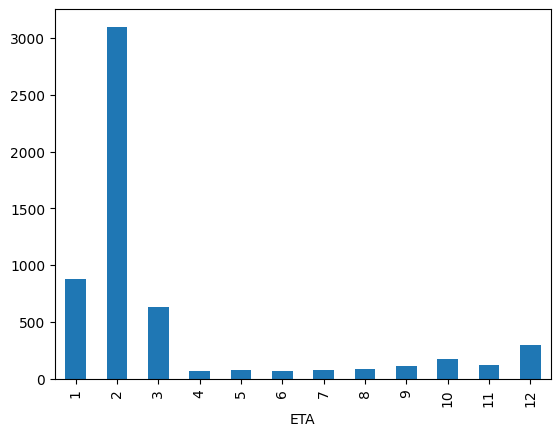

In [32]:
#df.groupby(df["date"].dt.month).count().plot(kind="bar")
df_bETA['ETA'].groupby(df_bETA.ETA.dt.month).count().plot(kind="bar")

<Axes: xlabel='filedate'>

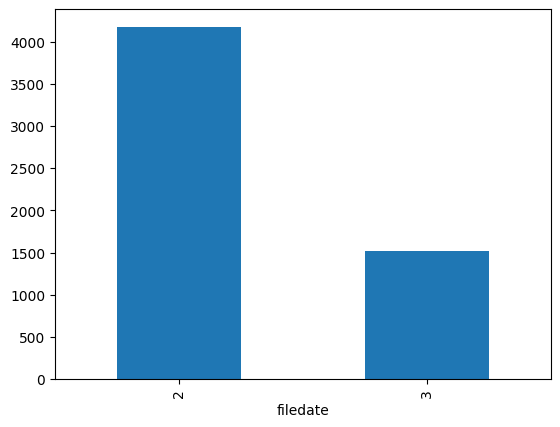

In [33]:
df_bETA['filedate'].groupby(df_bETA.filedate.dt.month).count().plot(kind="bar")

## ETA is later than file_date

In [37]:
df_bETA['eta_is_future'] = df_bETA.filedate=<df_bETA.ETA

SyntaxError: invalid syntax (3060685129.py, line 1)

In [38]:
len(df_bETA),df_bETA.eta_is_future.sum(),len(df_bETA)-df_bETA.eta_is_future.sum()

(5701, 2645, 3056)

<Axes: ylabel='ETA'>

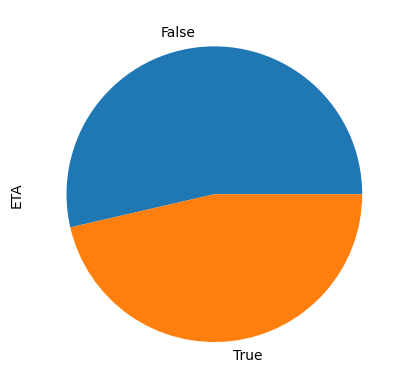

In [39]:
df_bETA.groupby('eta_is_future').ETA.count().plot(kind='pie')

## ETA is earlier than file_date

In [40]:
df_bETA['eta_is_past'] = df_bETA.filedate>=df_bETA.ETA

C:\Users\FernandoBadilla\AppData\Local\Temp\ipykernel_16536\2411054185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bETA['eta_is_past'] = df_bETA.filedate>=df_bETA.ETA


In [41]:
len(df_bETA),df_bETA.eta_is_past.sum(),len(df_bETA)-df_bETA.eta_is_past.sum()

(5701, 3056, 2645)

<Axes: ylabel='ETA'>

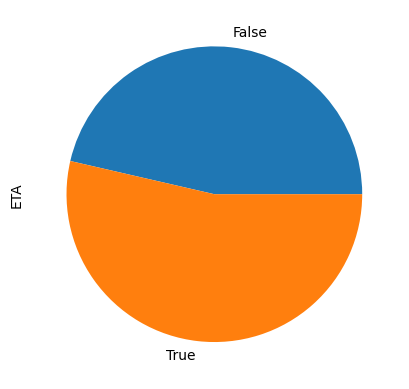

In [42]:
df_bETA.groupby('eta_is_past').ETA.count().plot(kind='pie')

## RECIEN CACHE QUE ERAN LLEGADAS PASADAS!

### 4. NOTA: del total inicial solo el 32% sirve

In [33]:
np.round(df_bETA.eta_is_future.sum() / len(df) *100,1)

32.1

In [34]:
df_gamma = df_bETA[ df_bETA.eta_is_future == True]

In [35]:
# llegadas futuras

# Group the rows by the Name column
grouped = df_gamma.groupby('Name')

# Compute the maximum date for each group
max_date = grouped['filedate'].transform('max')

# Select rows where the Date is equal to the maximum date for each group
result = df_gamma[df_gamma['filedate'] == max_date]


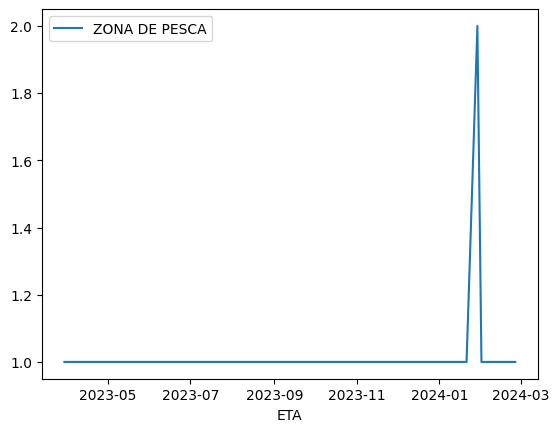

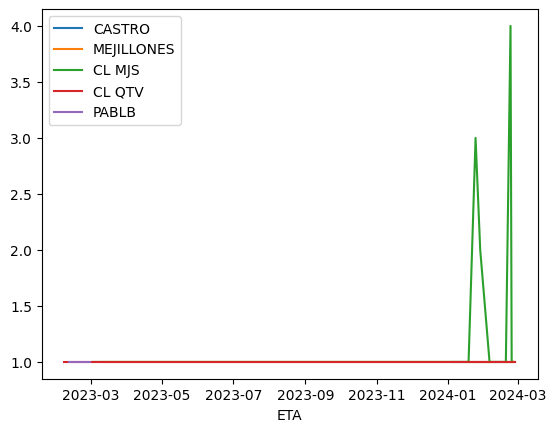

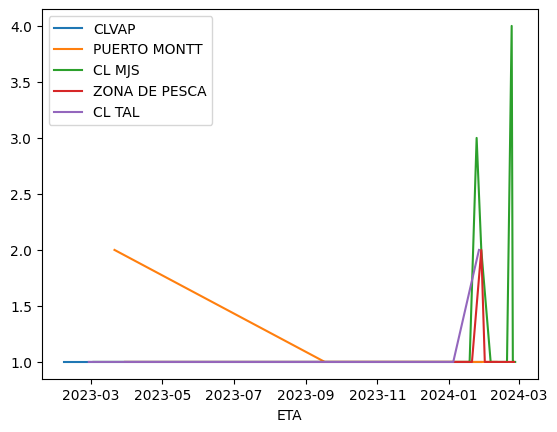

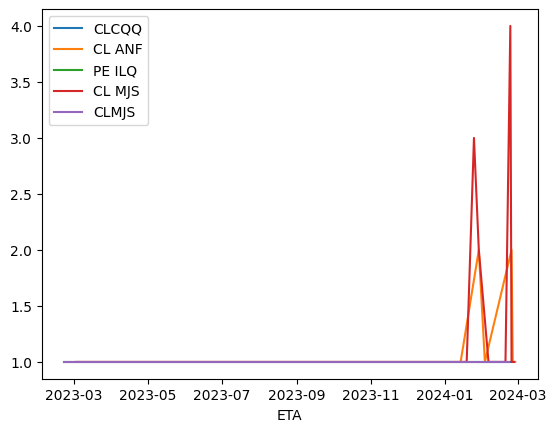

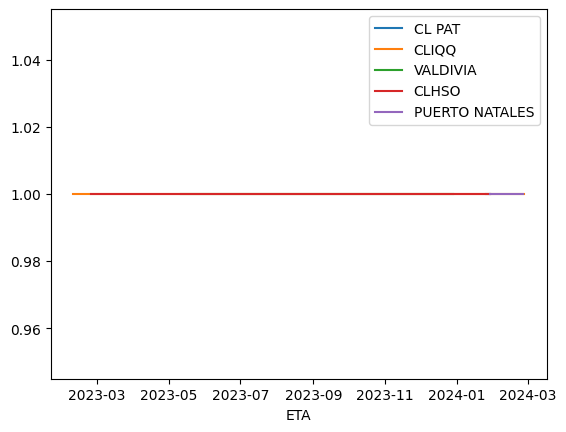

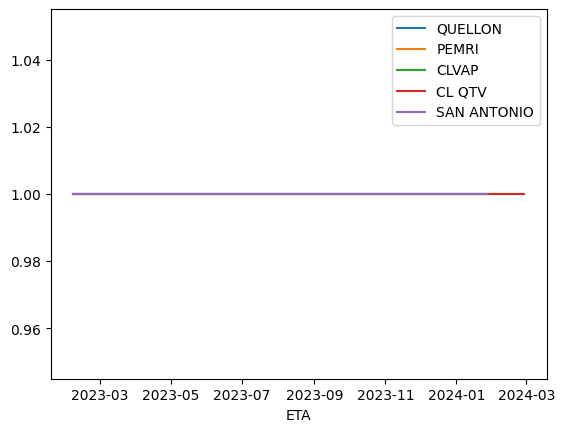

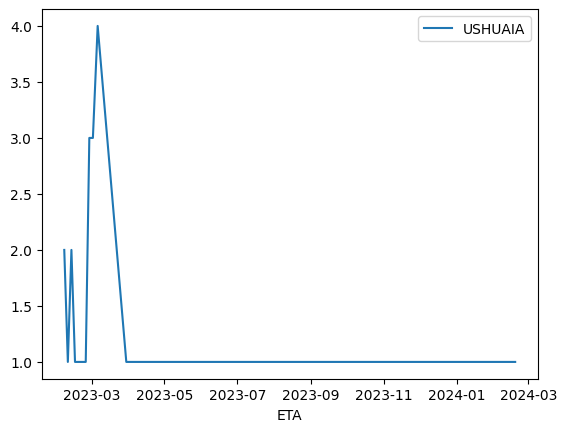

In [70]:
c=0
for d in result.Destination:
    tmp = result[result.Destination==d]
    if len(tmp)>1:
        tmp['Destination'].groupby(tmp.ETA.dt.date).count().plot(kind='line',label=d,legend=True)
        #plt.gca().set_title(d)
        #plt.show()
        if c%5==0:
            plt.show()
        if c>25:
            break
        c+=1


C:\Users\FernandoBadilla\source\pyenv\dev\lib\site-packages\pandas\plotting\_matplotlib\core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


ETA
2023-02-06    Axes(0.125,0.11;0.775x0.77)
2023-02-07    Axes(0.125,0.11;0.775x0.77)
2023-02-08    Axes(0.125,0.11;0.775x0.77)
2023-02-09    Axes(0.125,0.11;0.775x0.77)
2023-02-10    Axes(0.125,0.11;0.775x0.77)
                         ...             
2024-02-25    Axes(0.125,0.11;0.775x0.77)
2024-02-26    Axes(0.125,0.11;0.775x0.77)
2024-02-27    Axes(0.125,0.11;0.775x0.77)
2024-02-28    Axes(0.125,0.11;0.775x0.77)
2024-02-29    Axes(0.125,0.11;0.775x0.77)
Length: 216, dtype: object

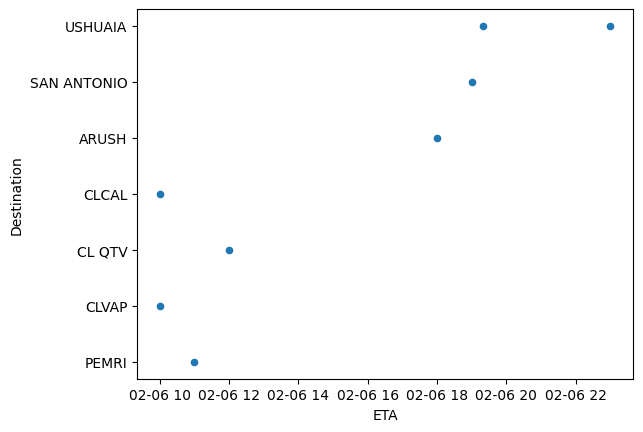

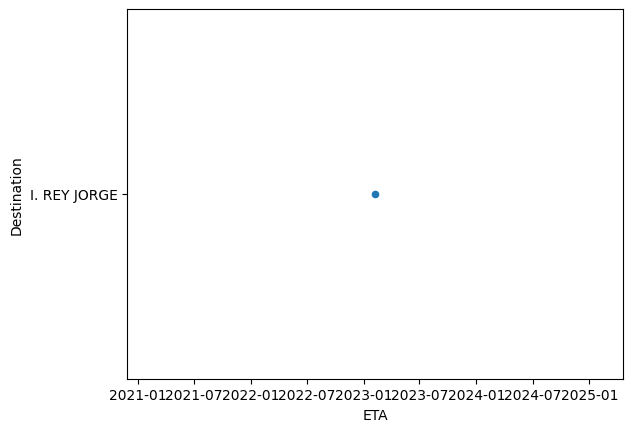

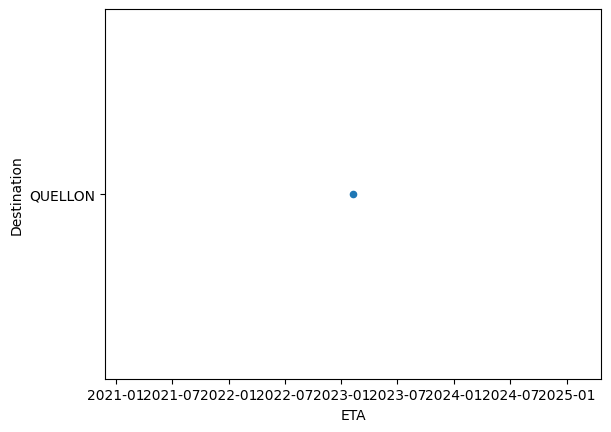

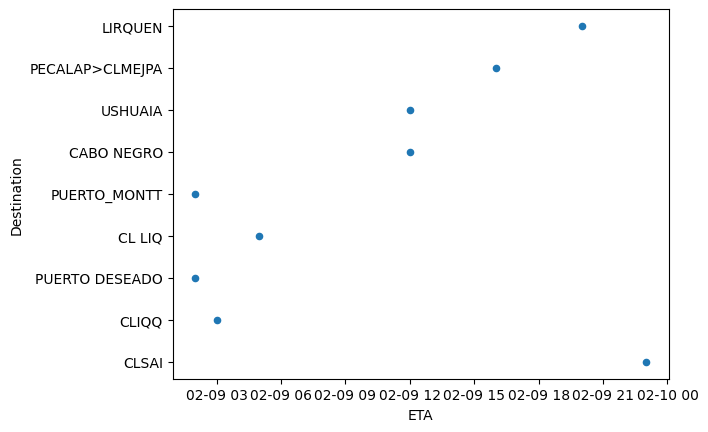

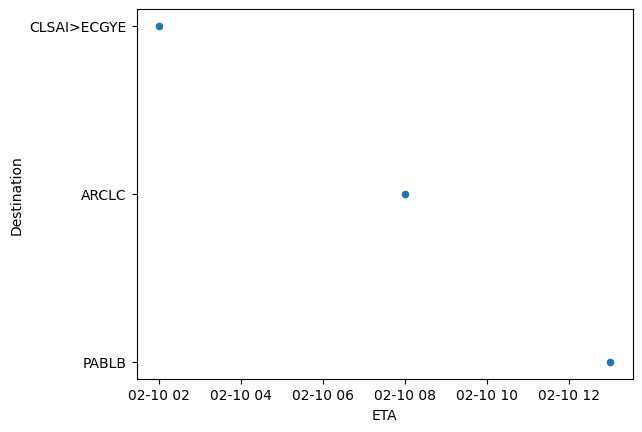

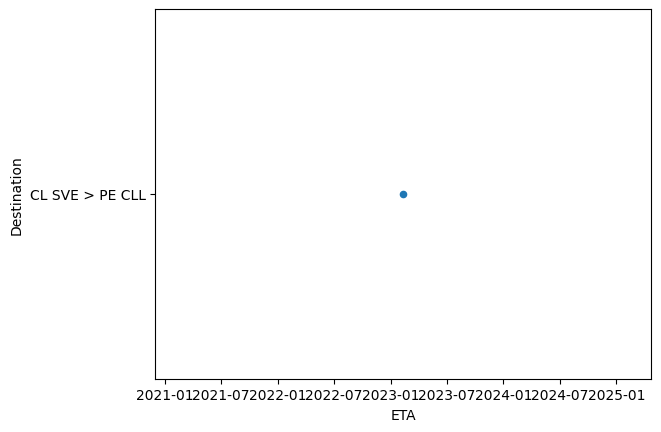

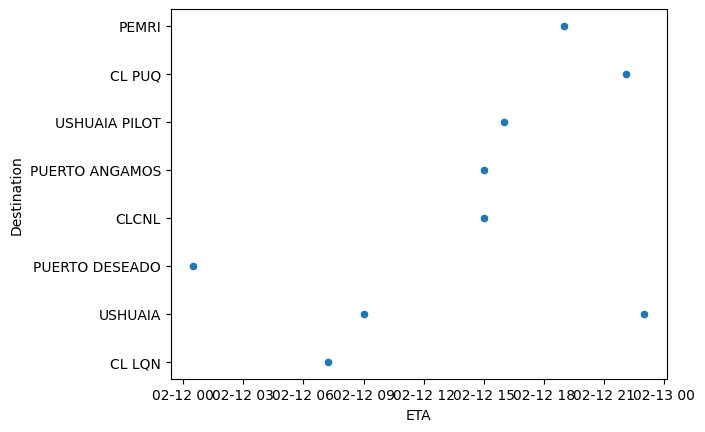

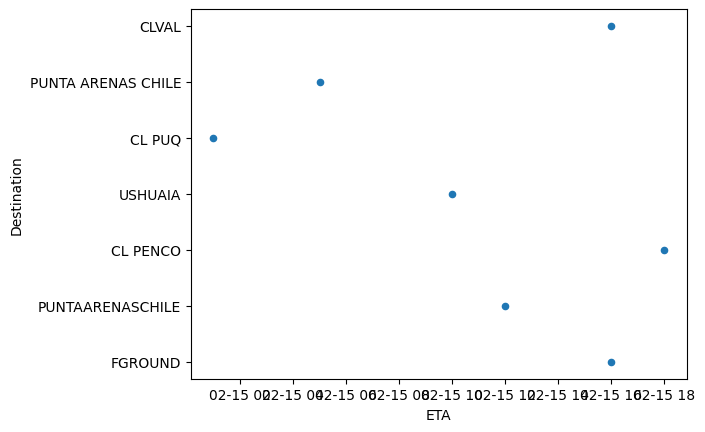

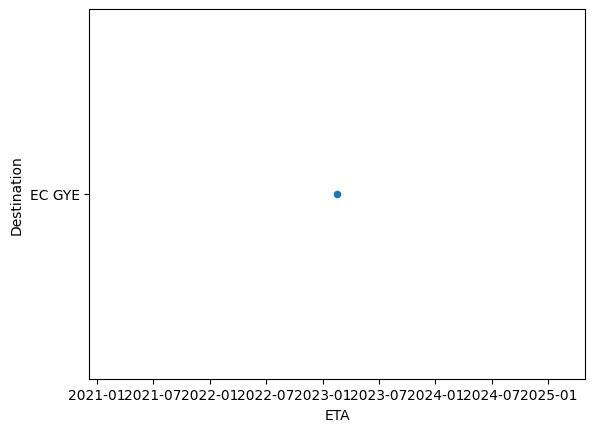

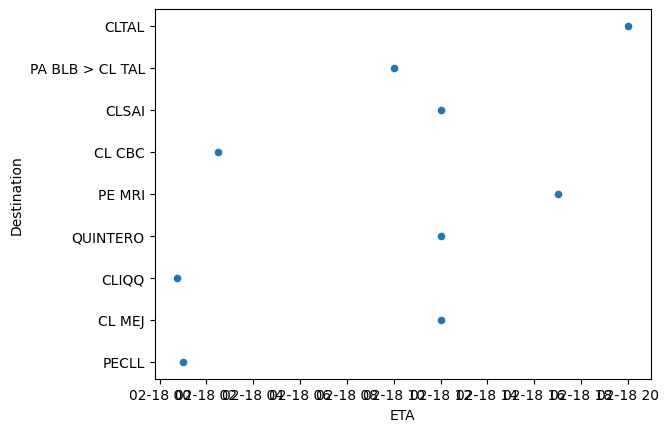

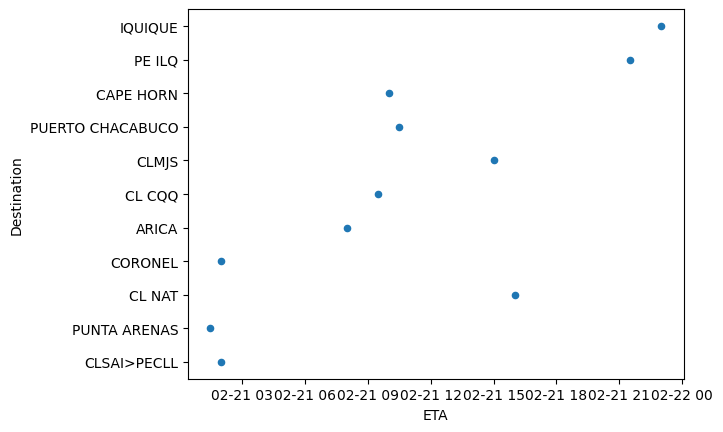

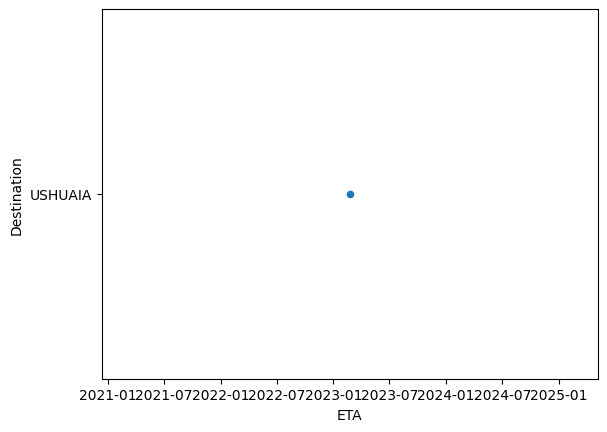

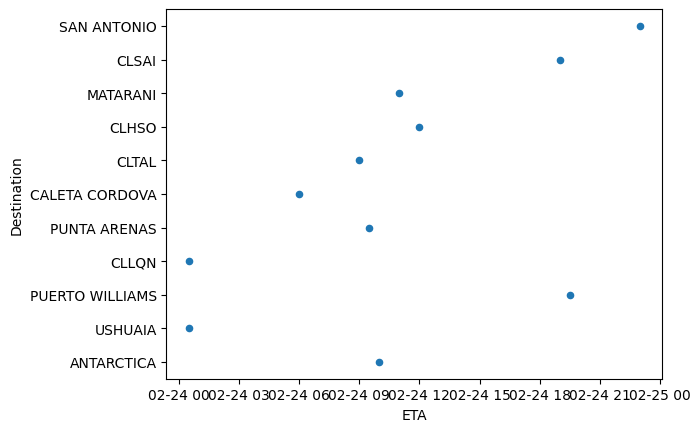

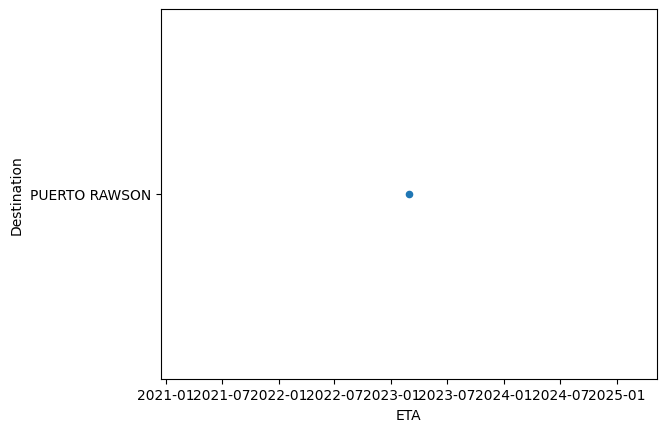

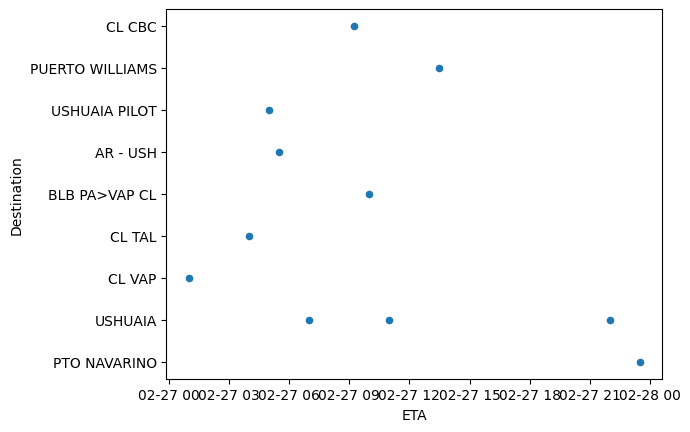

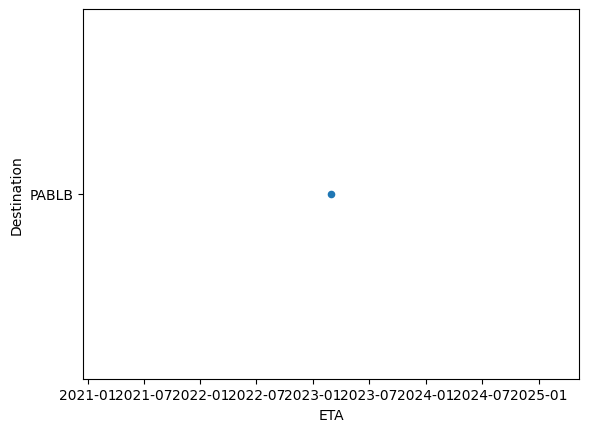

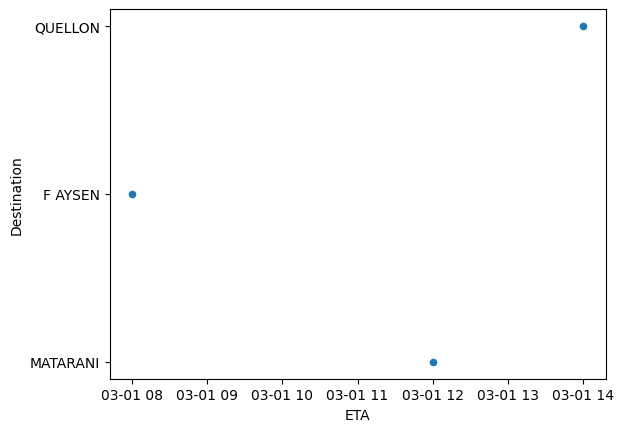

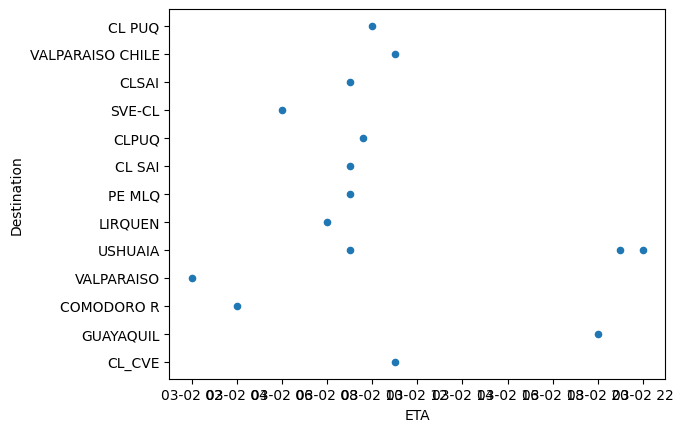

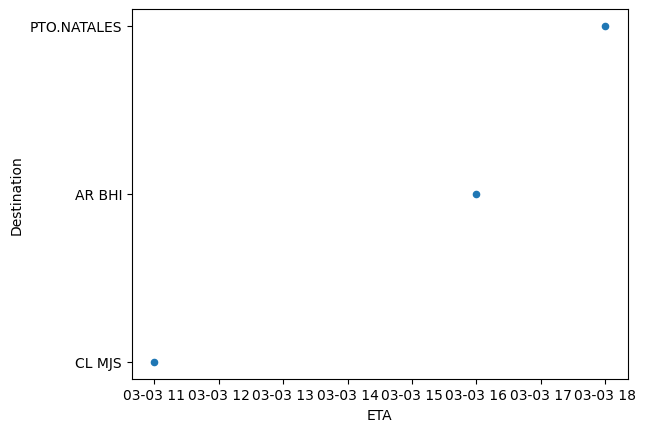

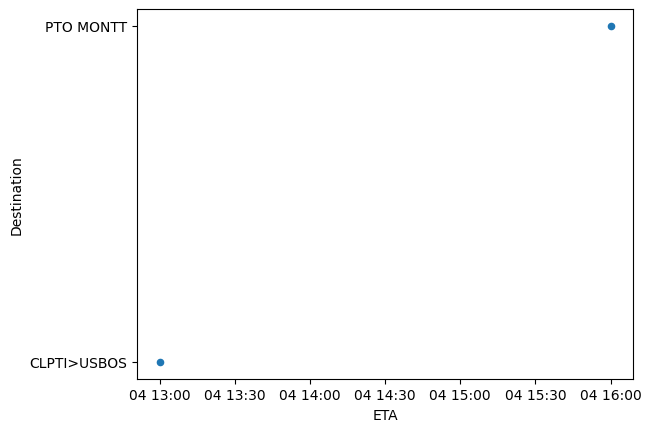

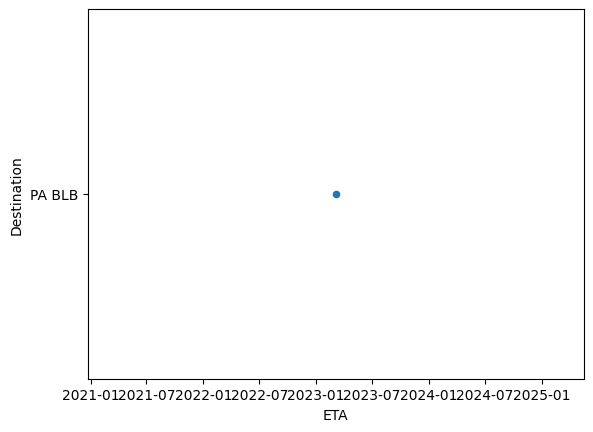

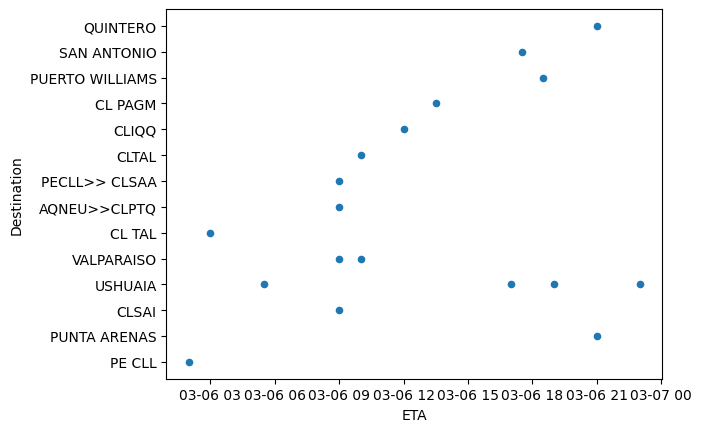

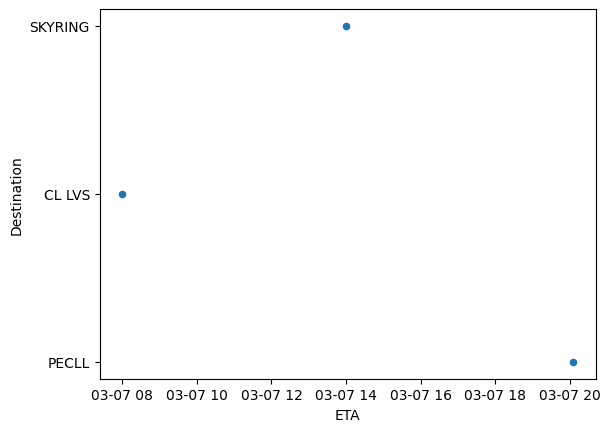

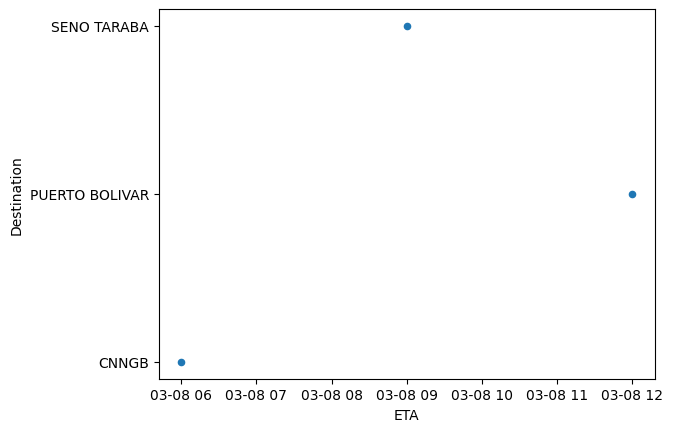

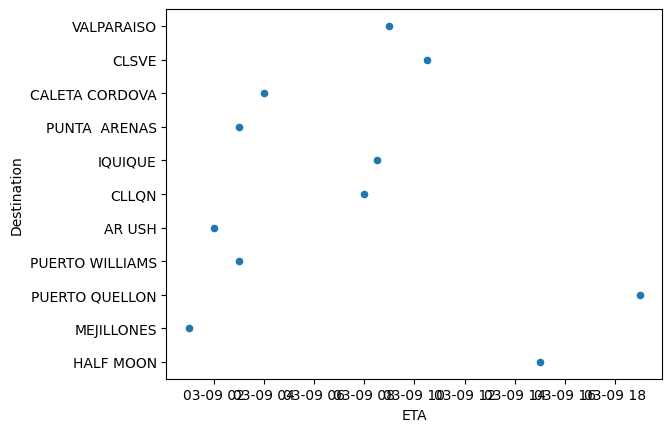

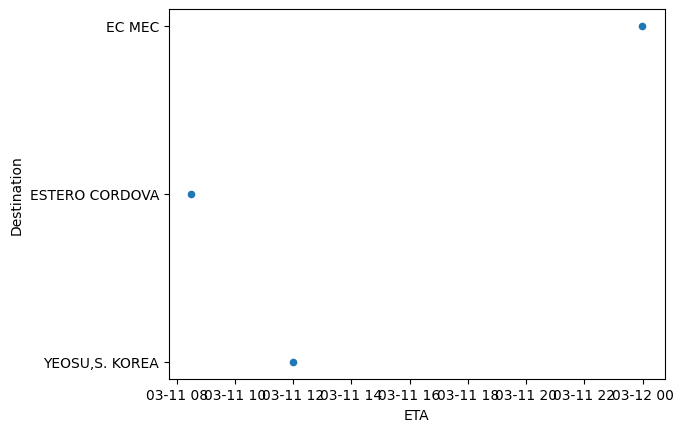

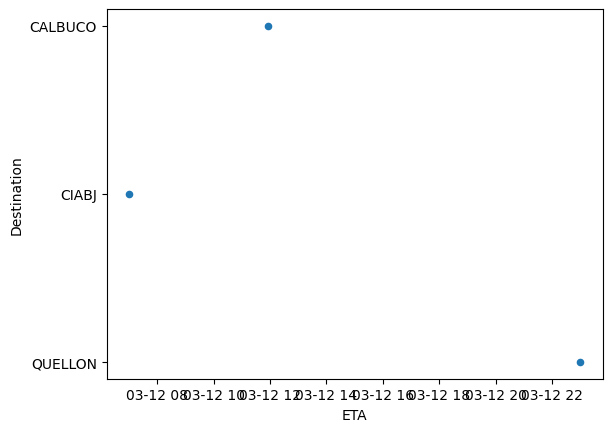

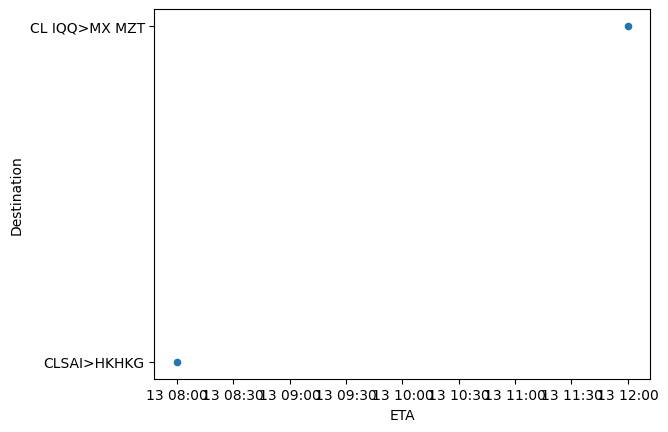

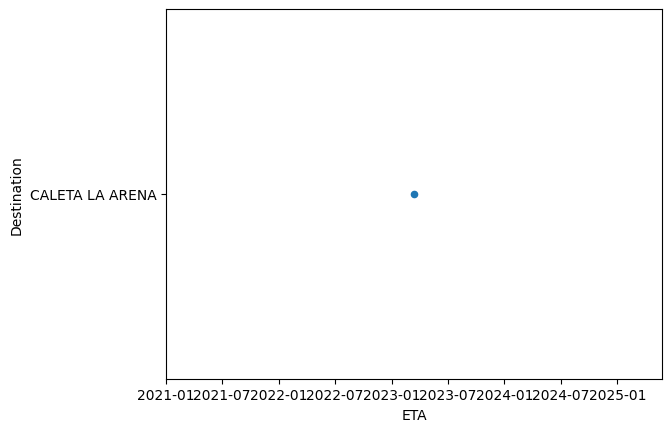

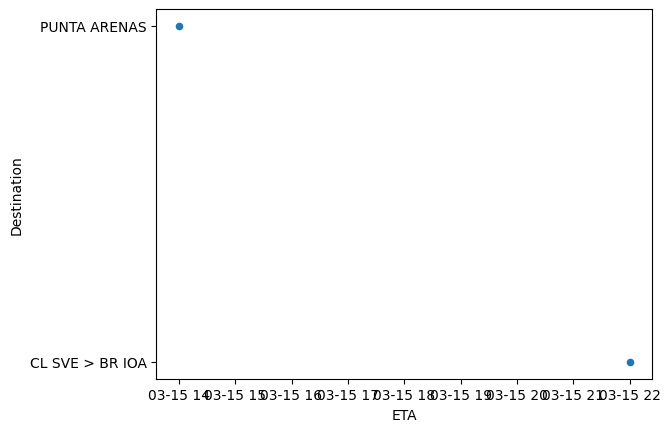

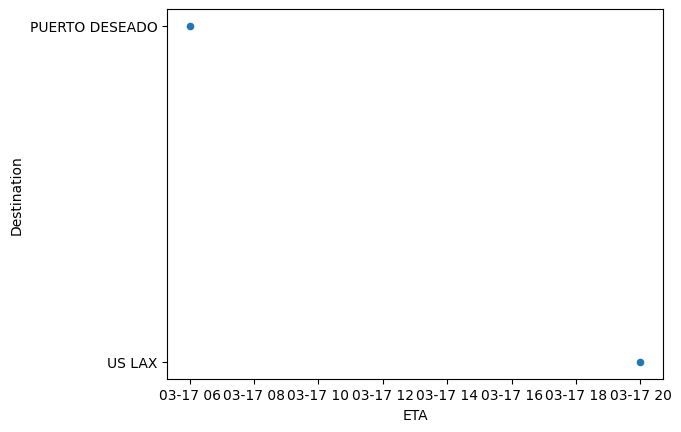

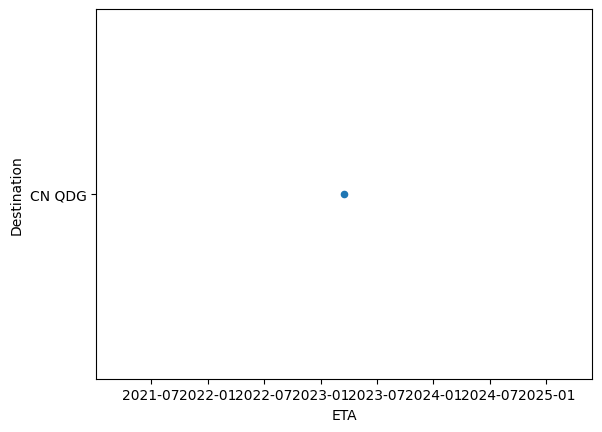

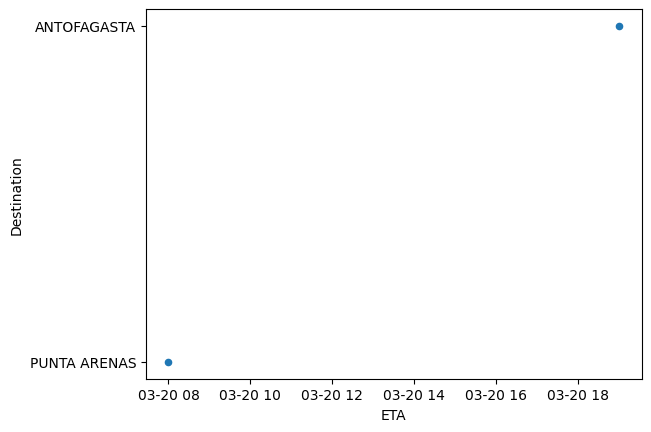

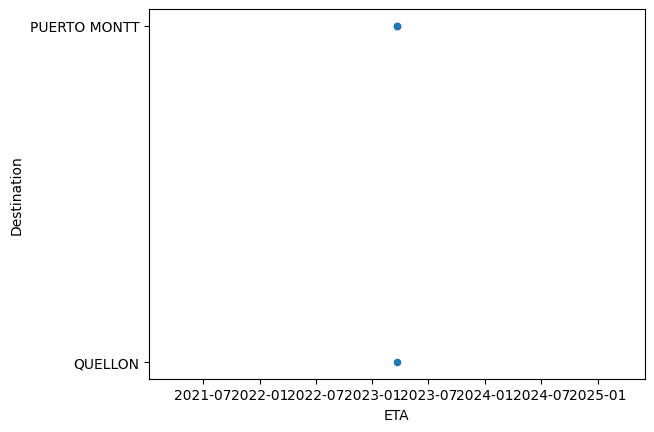

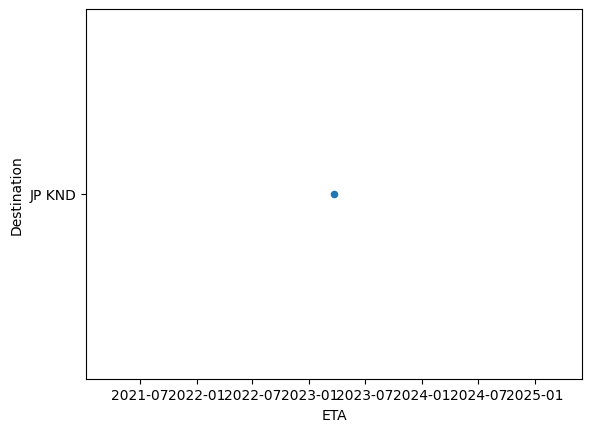

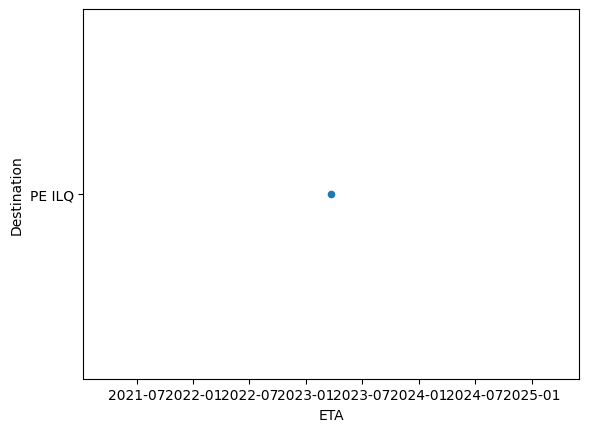

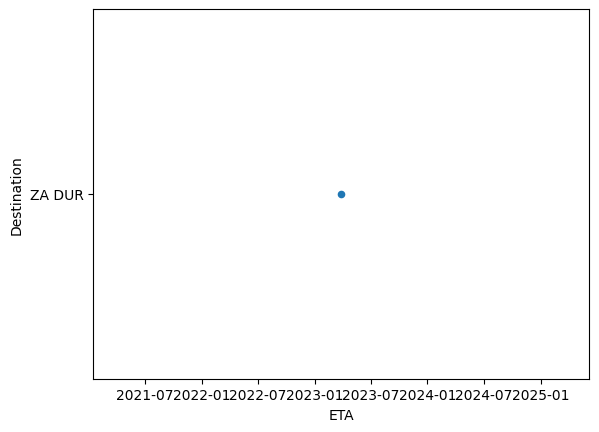

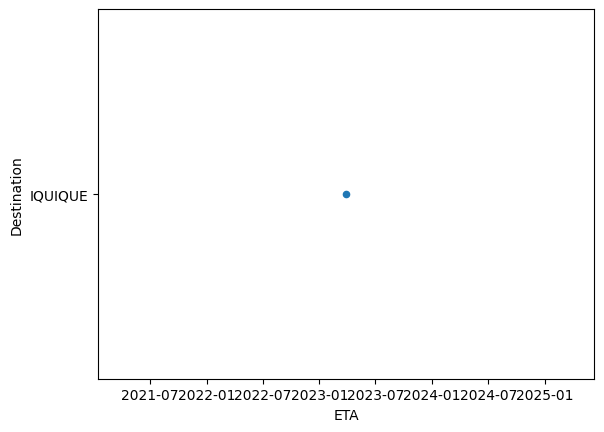

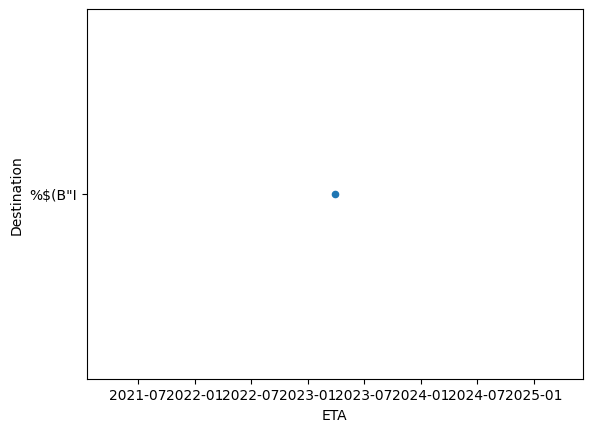

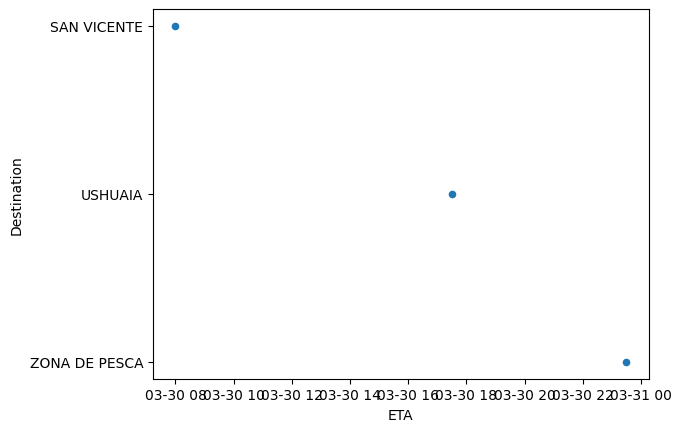

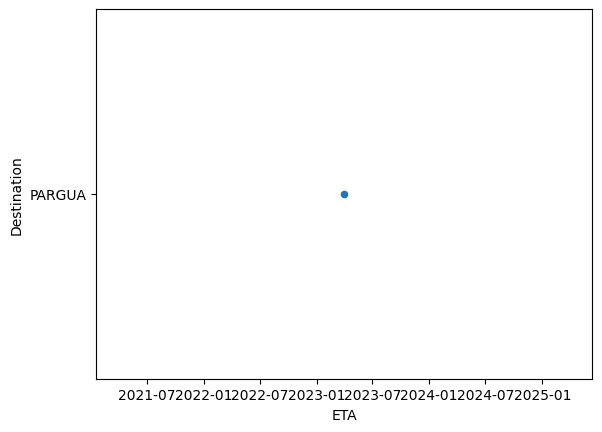

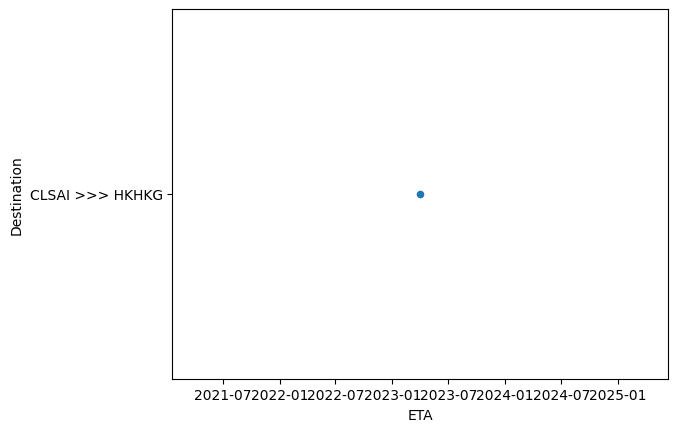

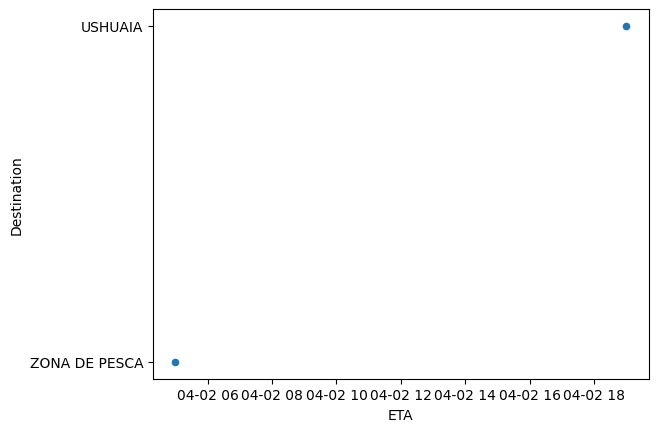

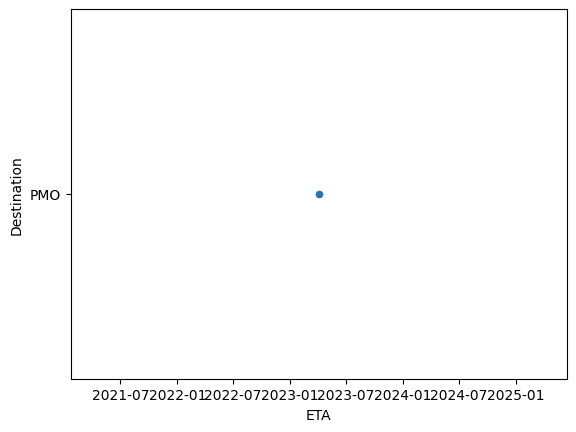

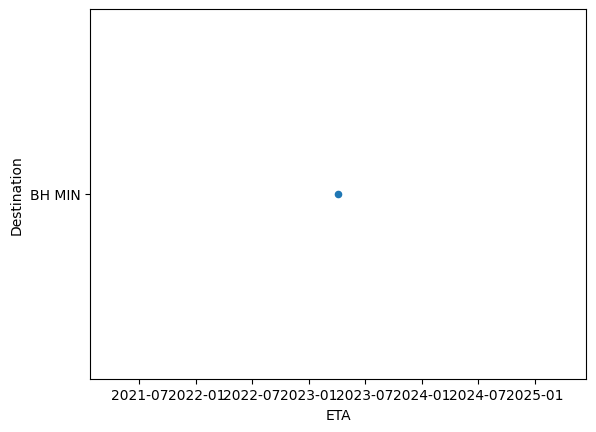

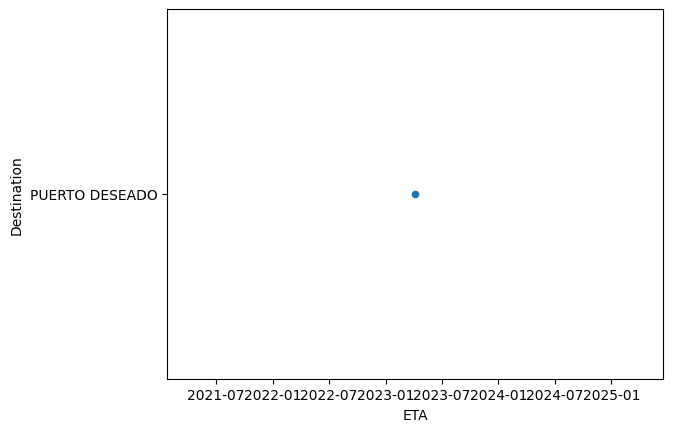

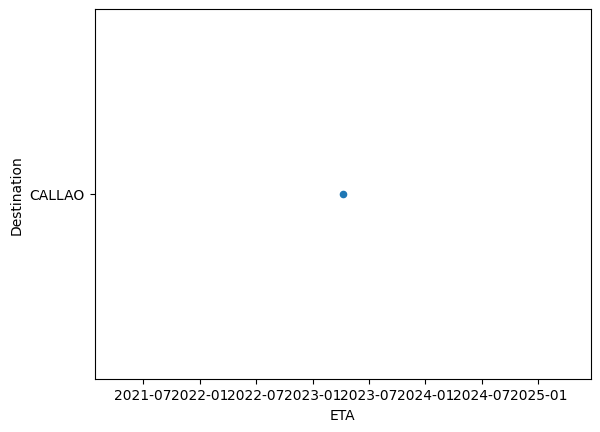

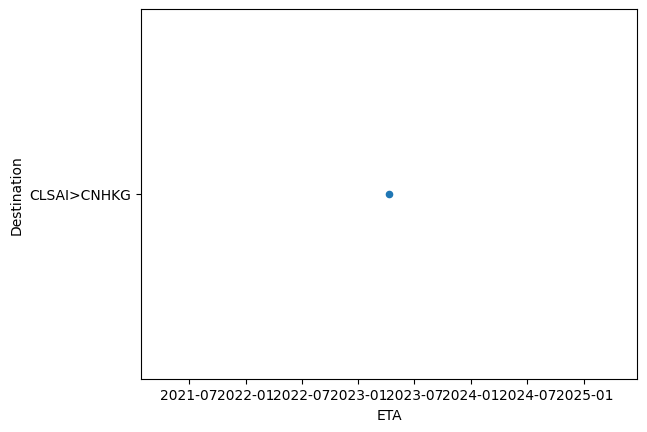

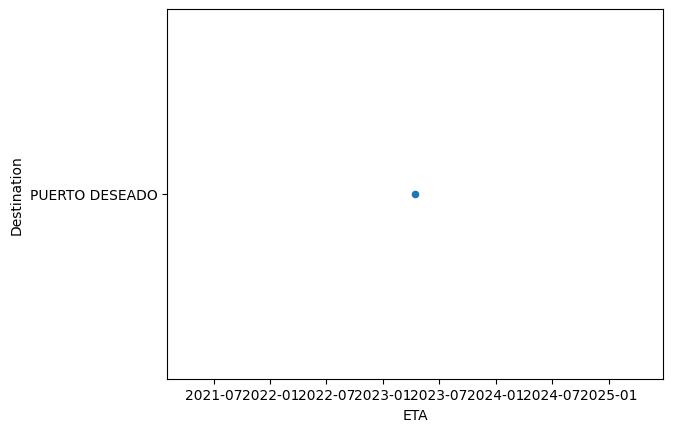

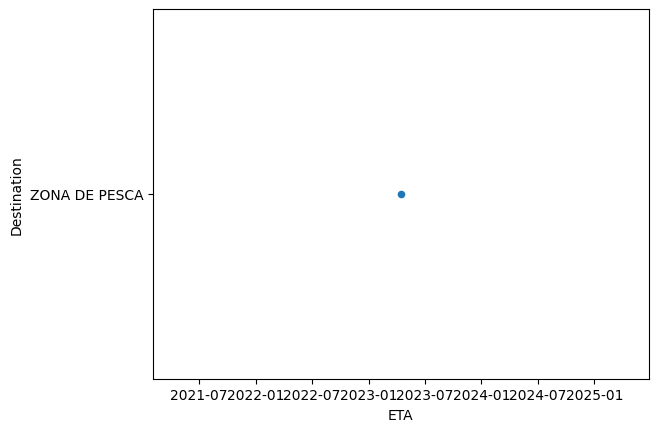

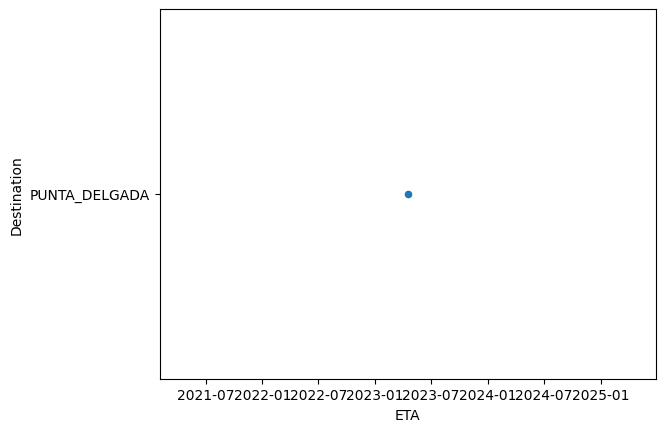

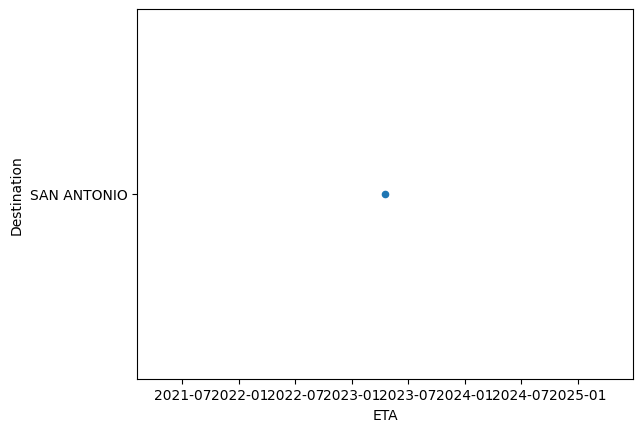

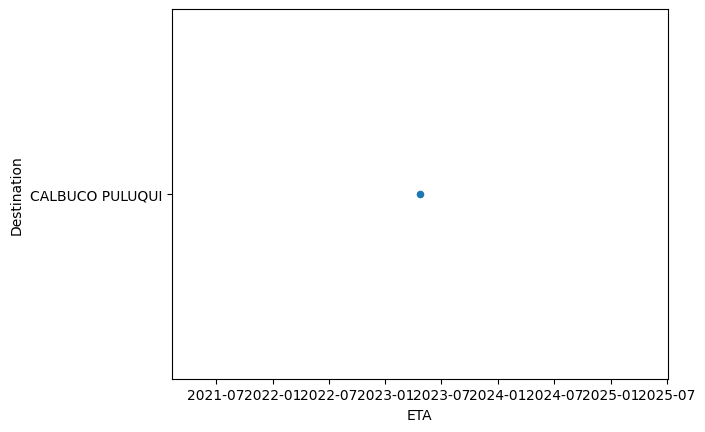

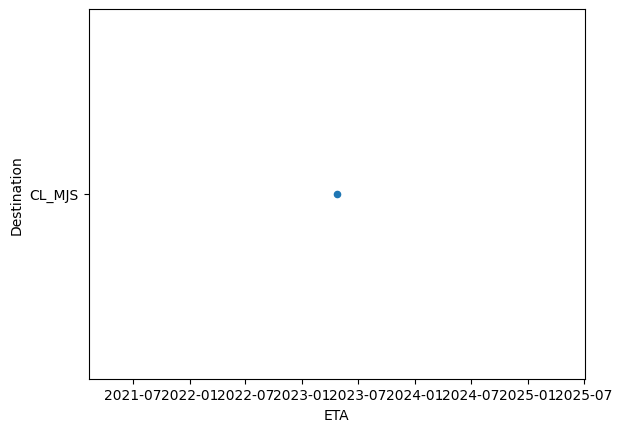

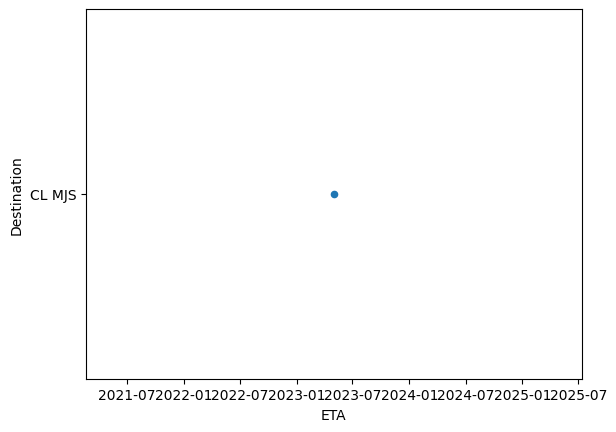

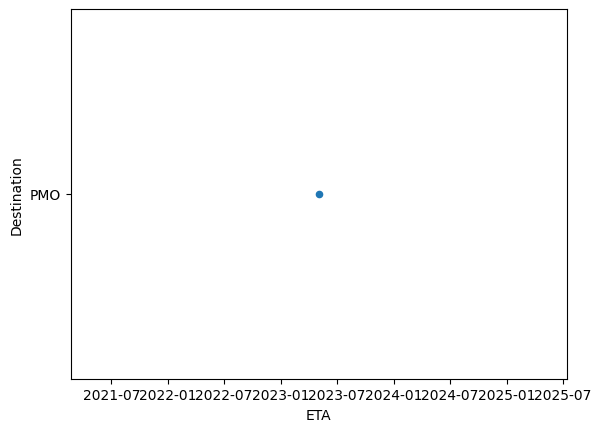

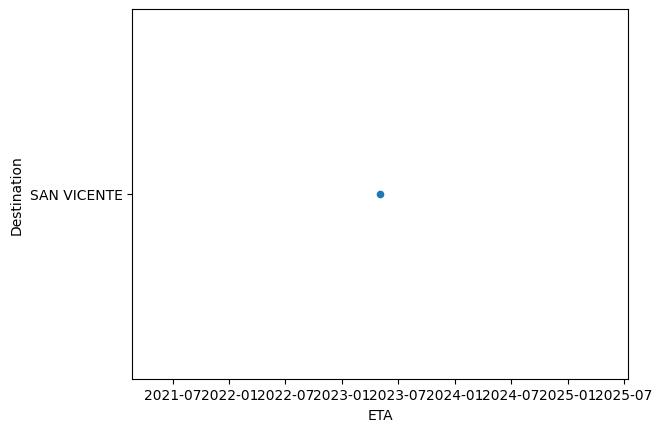

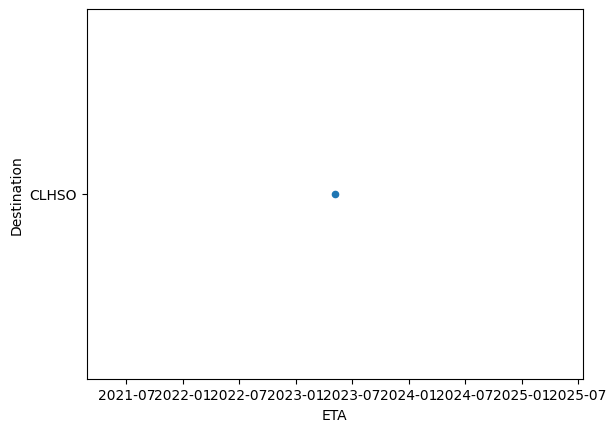

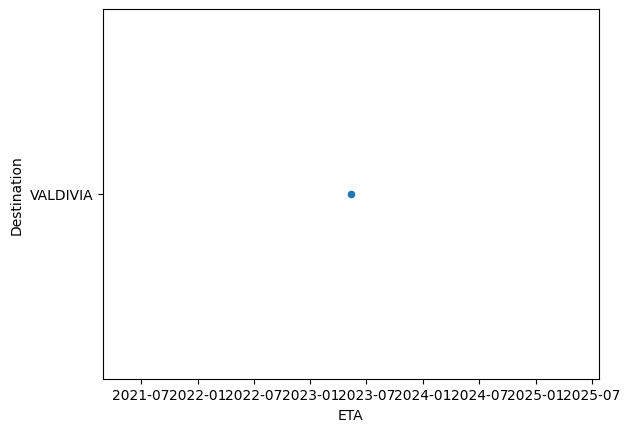

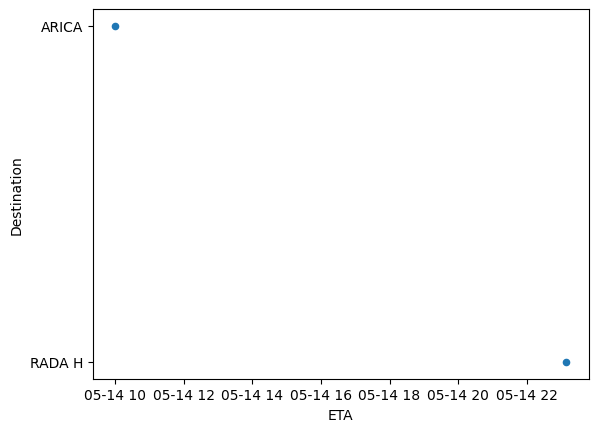

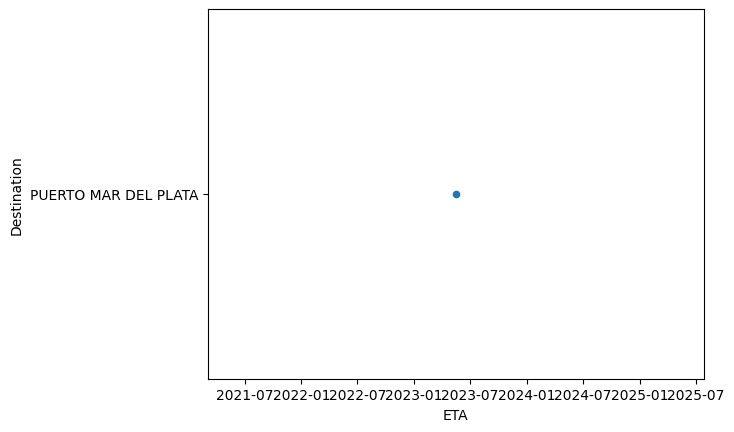

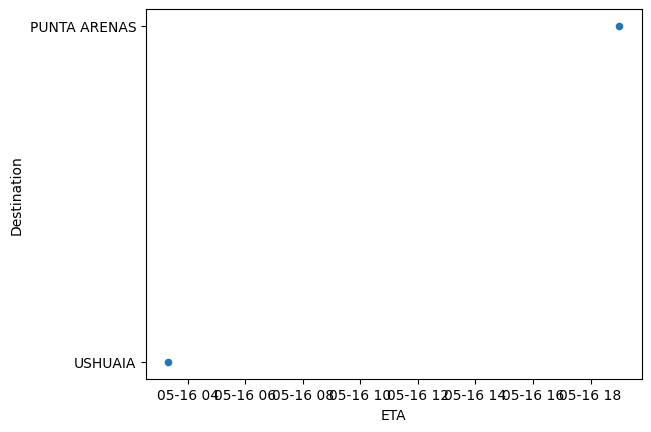

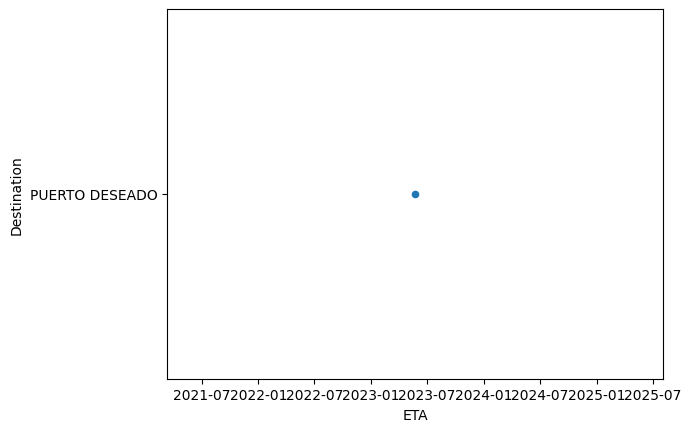

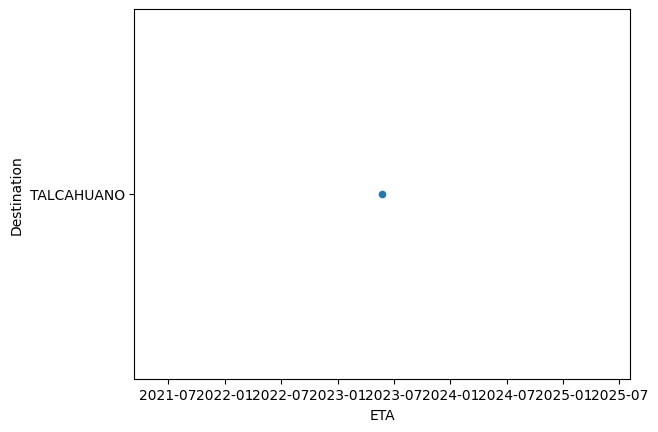

Error in callback <function flush_figures at 0x0000020EBD365E50> (for post_execute):


KeyboardInterrupt: 

In [74]:
result.groupby(result.ETA.dt.date).plot(kind='scatter',x='ETA',y='Destination')

# TRASH

<Axes: xlabel='Destination,ETA'>

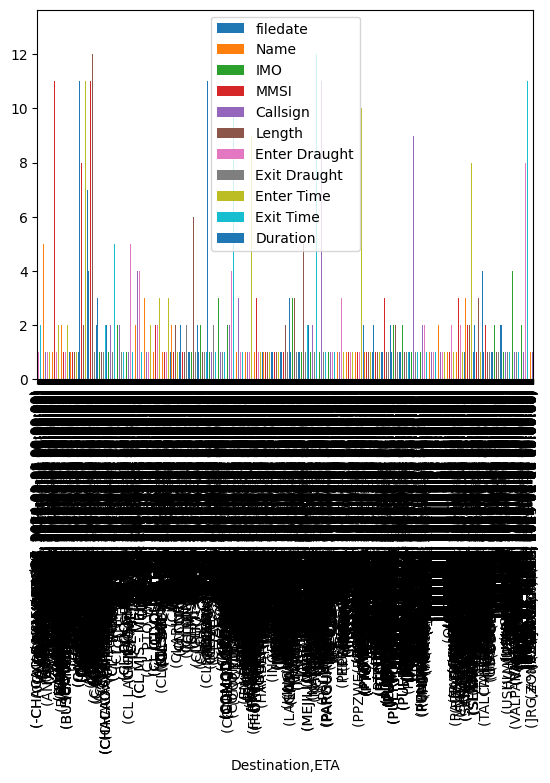

In [39]:
df.groupby([df["Destination"], df["ETA"]]).count().plot(kind="bar")

In [40]:
plt.show()

In [ ]:
df.groupby(